In [1]:
import xarray as xr
from matplotlib import pyplot as plt
plt.style.use('./grl.mplstyle')
import os
os.environ['PATH'] = os.environ['PATH'] + ':/Library/TeX/texbin/'
import numpy as np
import xrft

### Over time

In [170]:
######## Read in ##########
# NL = 15
ds1 = xr.open_mfdataset(
    '../../multilayer/JFM2023/compilation/C4/field*.nc', 
    concat_dim='t', combine='nested', chunks={'x':-1, 'y':-1})  
del ds1.attrs['t']
ds1 = ds1.chunk({'x':-1, 'y':-1})
# NL = 30
ds2 = xr.open_mfdataset(
    '../../multilayer/JFM2023/compilation/Cvalid1/field*.nc', 
    concat_dim='t', combine='nested', chunks={'x':-1, 'y':-1})  
del ds2.attrs['t']
ds2 = ds2.chunk({'x':-1, 'y':-1})
# NL = 45
ds3 = xr.open_mfdataset(
    '../../multilayer/JFM2023/compilation/Cvalid2/field*.nc', 
    concat_dim='t', combine='nested', chunks={'x':-1, 'y':-1})  
del ds3.attrs['t']
ds3 = ds3.chunk({'x':-1, 'y':-1})

In [174]:
''' Lazy compute of surface spectrum '''

window = 'hann'
nfactor = 4
truncate = True
detrend = None
window_correction = True

ds = ds2
print('Surface at depth %g' %ds.z.isel(zl=-1).mean(dim=['x','y','t']))

Fux = xrft.isotropic_power_spectrum(ds.ux.isel(zl=-1).drop(['z']), dim=('x','y'), window=window, nfactor=nfactor, 
                                truncate=truncate, detrend=detrend, window_correction=window_correction)
Fuy = xrft.isotropic_power_spectrum(ds.uy.isel(zl=-1).drop(['z']), dim=('x','y'), window=window, nfactor=nfactor, 
                                truncate=truncate, detrend=detrend, window_correction=window_correction)
Fuz = xrft.isotropic_power_spectrum(ds.uz.isel(zl=-1).drop(['z']), dim=('x','y'), window=window, nfactor=nfactor, 
                                truncate=truncate, detrend=detrend, window_correction=window_correction)
Feta = xrft.isotropic_power_spectrum(ds.z.isel(zl=-1).drop(['z']), dim=('x','y'), window=window, nfactor=nfactor, 
                                truncate=truncate, detrend=detrend, window_correction=window_correction)

Surface at depth -0.0583861


In [74]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    %time Fux.compute()

[########################################] | 100% Completed | 3.26 sms
CPU times: user 3.24 s, sys: 618 ms, total: 3.85 s
Wall time: 3.27 s


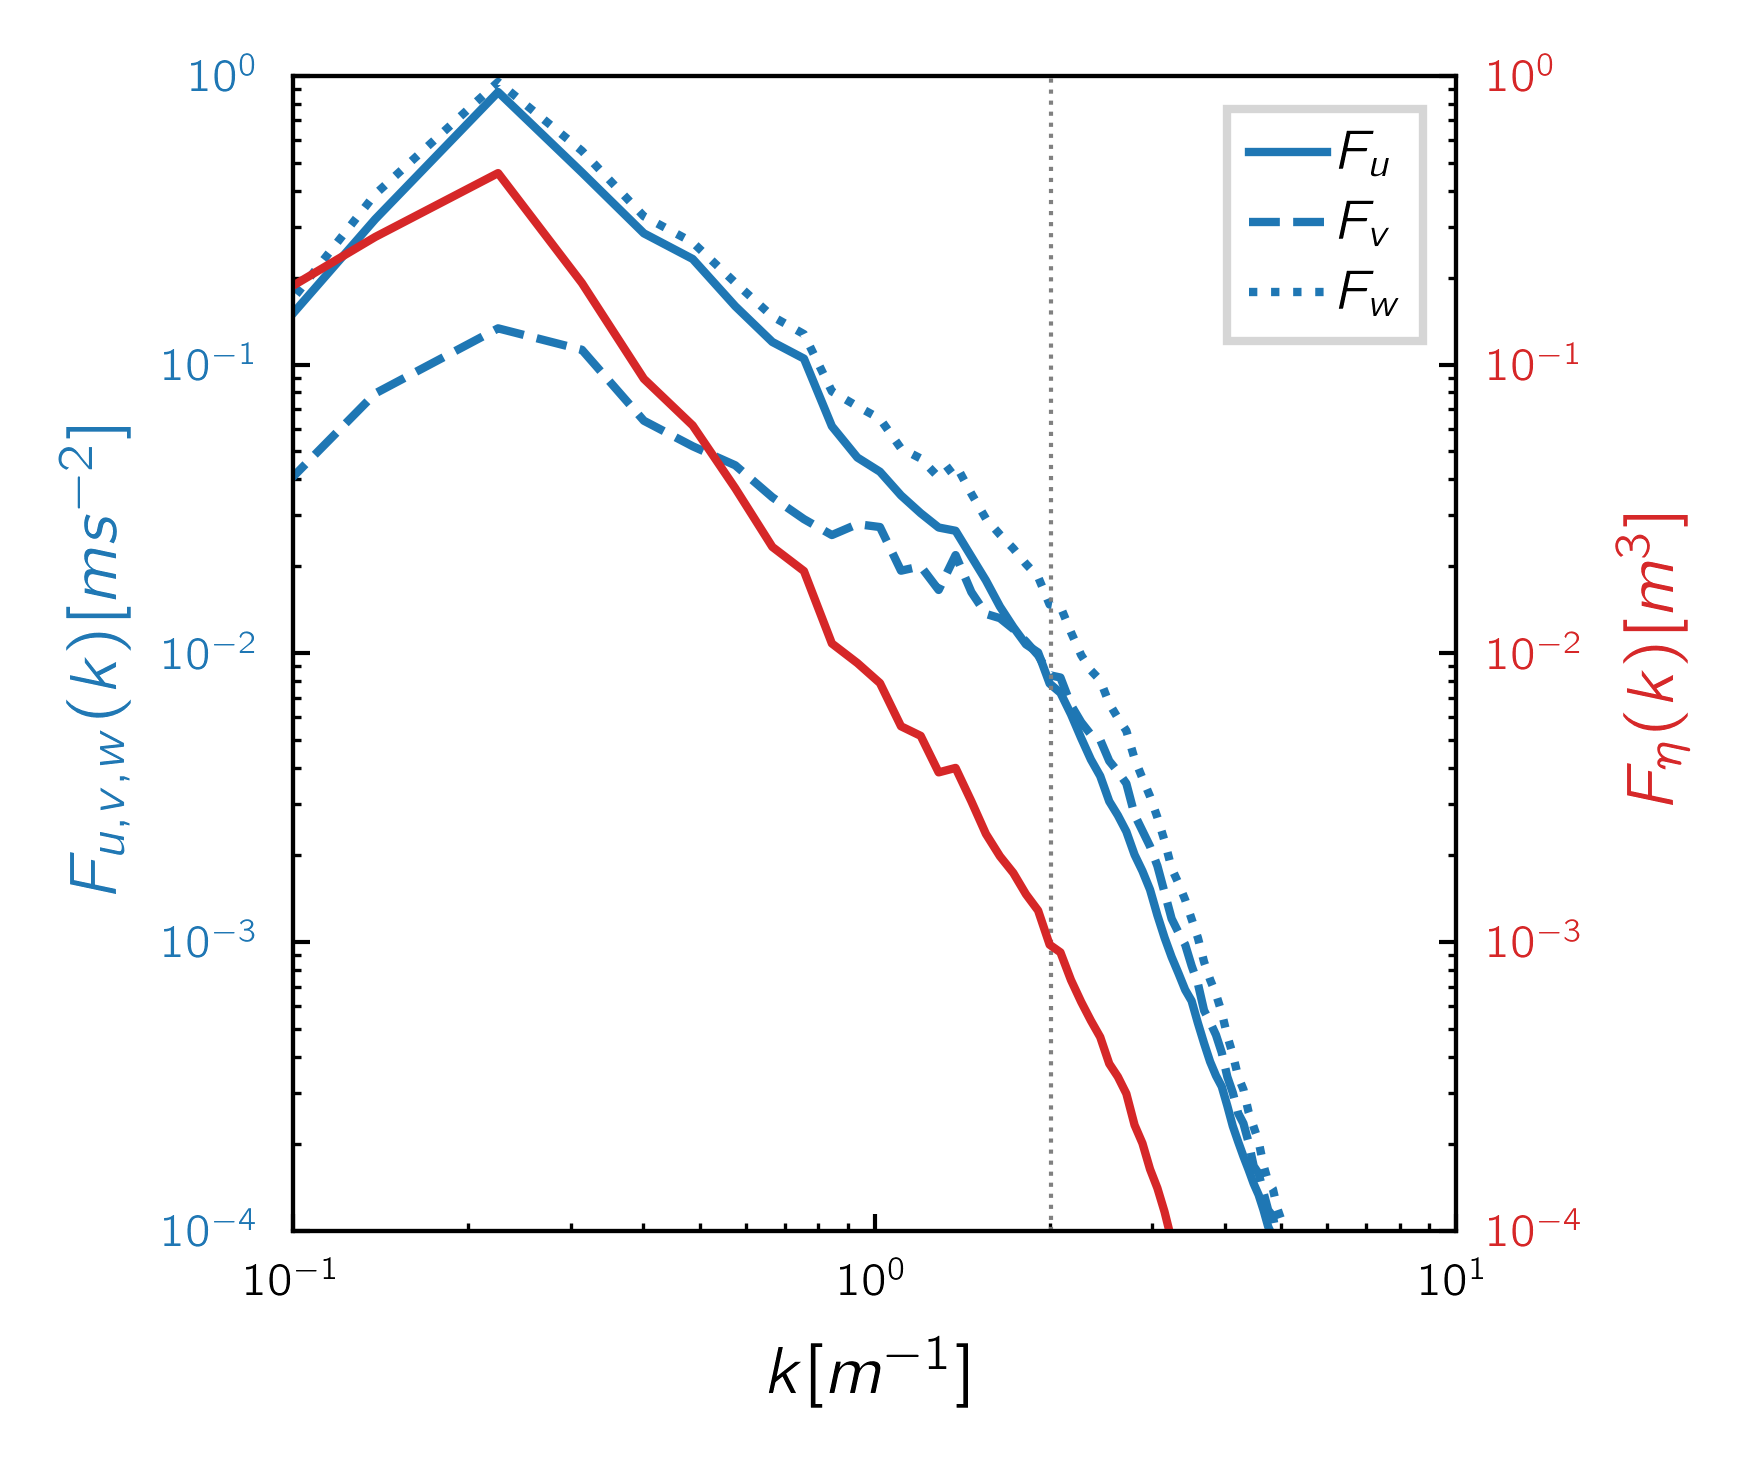

In [178]:
fig = plt.figure(figsize=[2.5,2.5]); ax1 = plt.gca()

lss = ['-', '--', ':']

# compute spectrum
Fux_aver = Fux.sel(t=[150,160,170]).mean('t').compute()
Fuy_aver = Fuy.sel(t=[150,160,170]).mean('t').compute()
Fuz_aver = Fuz.sel(t=[150,160,170]).mean('t').compute()
Feta_aver = Feta.sel(t=[150,160,170]).mean('t').compute()

# plot velocity spectrum
color = 'tab:blue'
ax1.plot(Fux.freq_r*np.pi*2, Fux_aver, lw=1, ls=lss[0], label=r'$F_u$', c=color)
ax1.plot(Fuy.freq_r*np.pi*2, Fuy_aver, lw=1, ls=lss[1], label=r'$F_v$', c=color)
ax1.plot(Fuz.freq_r*np.pi*2, Fuz_aver, lw=1, ls=lss[2], label=r'$F_w$', c=color)

ax1.set_xlabel(r'$k [m^{-1}]$')
ax1.set_ylabel(r'$F_{u,v,w}(k) [ms^{-2}]$', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale('log'); ax1.set_xscale('log')
ax1.set_ylim([10**(-4),1]); ax1.set_xlim([10**(-1),10])

# plot elevation spectrum
ax2 = ax1.twinx()
color = 'tab:red'
ax2.plot(Feta.freq_r*np.pi*2, Feta_aver, lw=1, c=color)

ax2.set_ylabel(r'$F_{\eta}(k) [m^3]$', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale('log'); ax2.set_xscale('log')
ax2.set_ylim([10**(-4),1])

ax1.axvline(x=(1024/16)/200*2*np.pi, linestyle=':', c='gray')
ax1.legend()

# Optional: add a slope, but it's not isotropic 
# x_vals = np.linspace(1,2)
# y_vals = x_vals**(-5/3)*0.1
# plt.plot(x_vals, y_vals, '--', c='grey')

plt.savefig('../figures/multilayer-diss/spectrum1.pdf', bbox_inches='tight', pad_inches=0)

Mean vertical position -0.0369739
Mean vertical position -6.05012


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


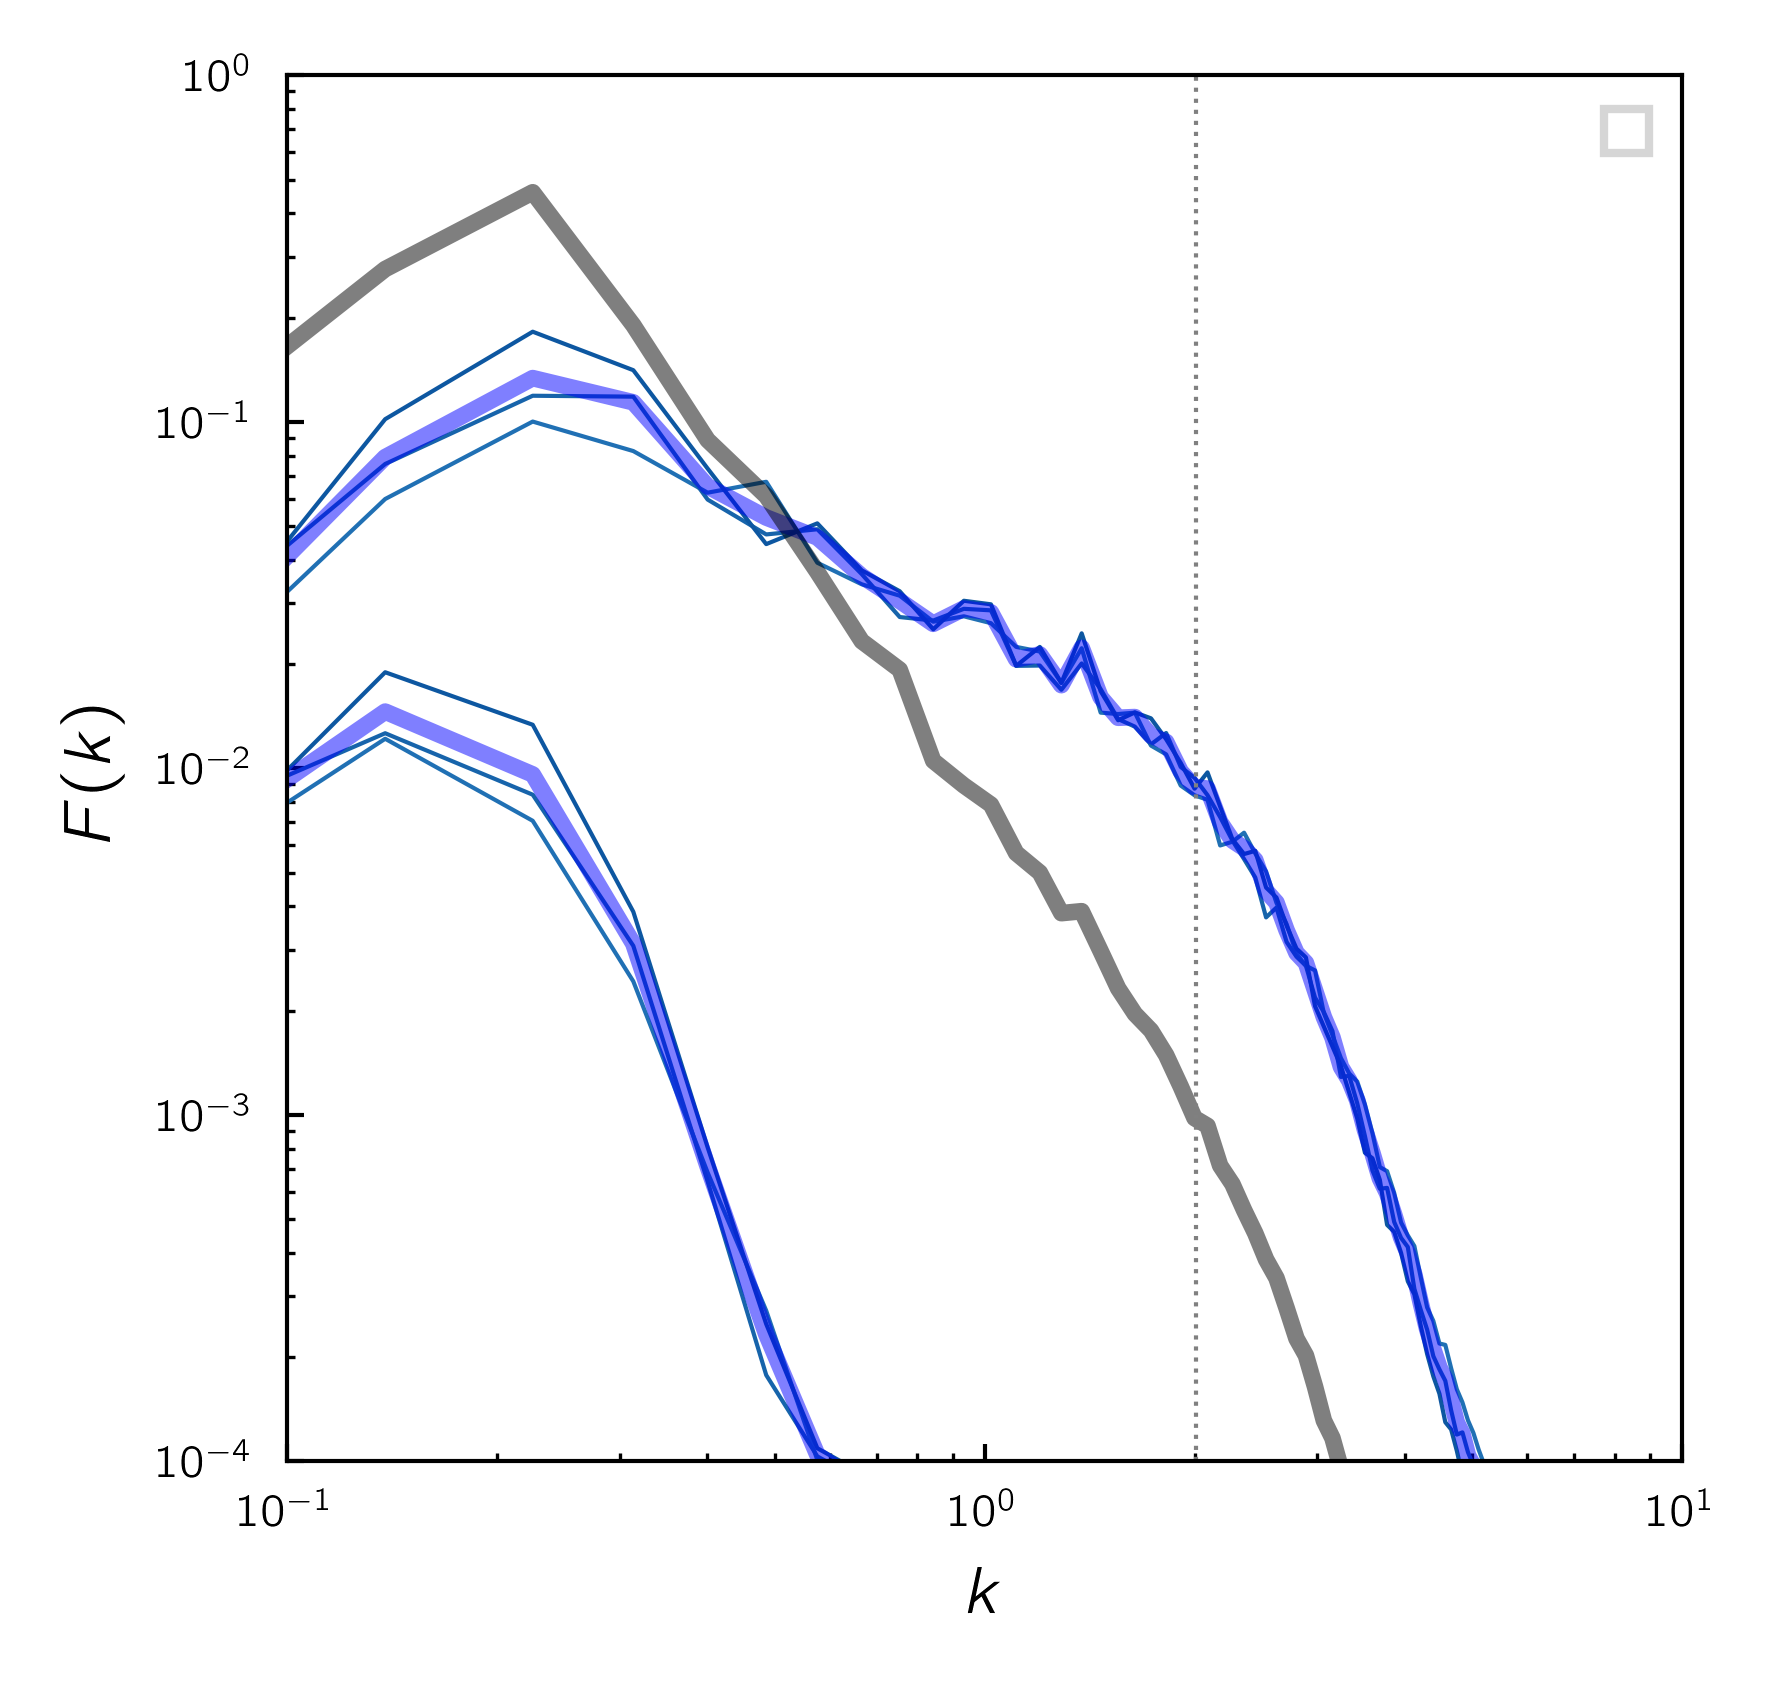

In [108]:
''' Check velocity spectrum different times and different depth and compare with wave spectrum '''

plt.figure(figsize=[3,3])

for j in (44,20): # depth
    print('Mean vertical position %g' %ds.z.isel(zl=j).mean(dim=['t','x','y']))
    for t in [150,160,170]: #time
        plt.plot(Fuy.freq_r*np.pi*2, Fuy.sel(t=t,zl=j), 
                    c=plt.get_cmap('Blues')(t/200), linestyle=linestyles[0])
    
    plt.plot(Fuy.freq_r*np.pi*2, Fuy.sel(t=[150,160,170],zl=j).mean('t'), lw=2, alpha=0.5, c='b')
    
plt.plot(Feta.freq_r*np.pi*2, Feta.sel(t=[150,160,170],zl=44).mean('t'), lw=2, alpha=0.5, c='k')

plt.xlabel('$k$')
plt.ylabel('$F(k)$')
plt.yscale('log'); plt.xscale('log')
plt.ylim([10**(-4),1]); plt.xlim([10**(-1),10])
plt.axvline(x=(1024/16)/200*2*np.pi, linestyle=':', c='gray')

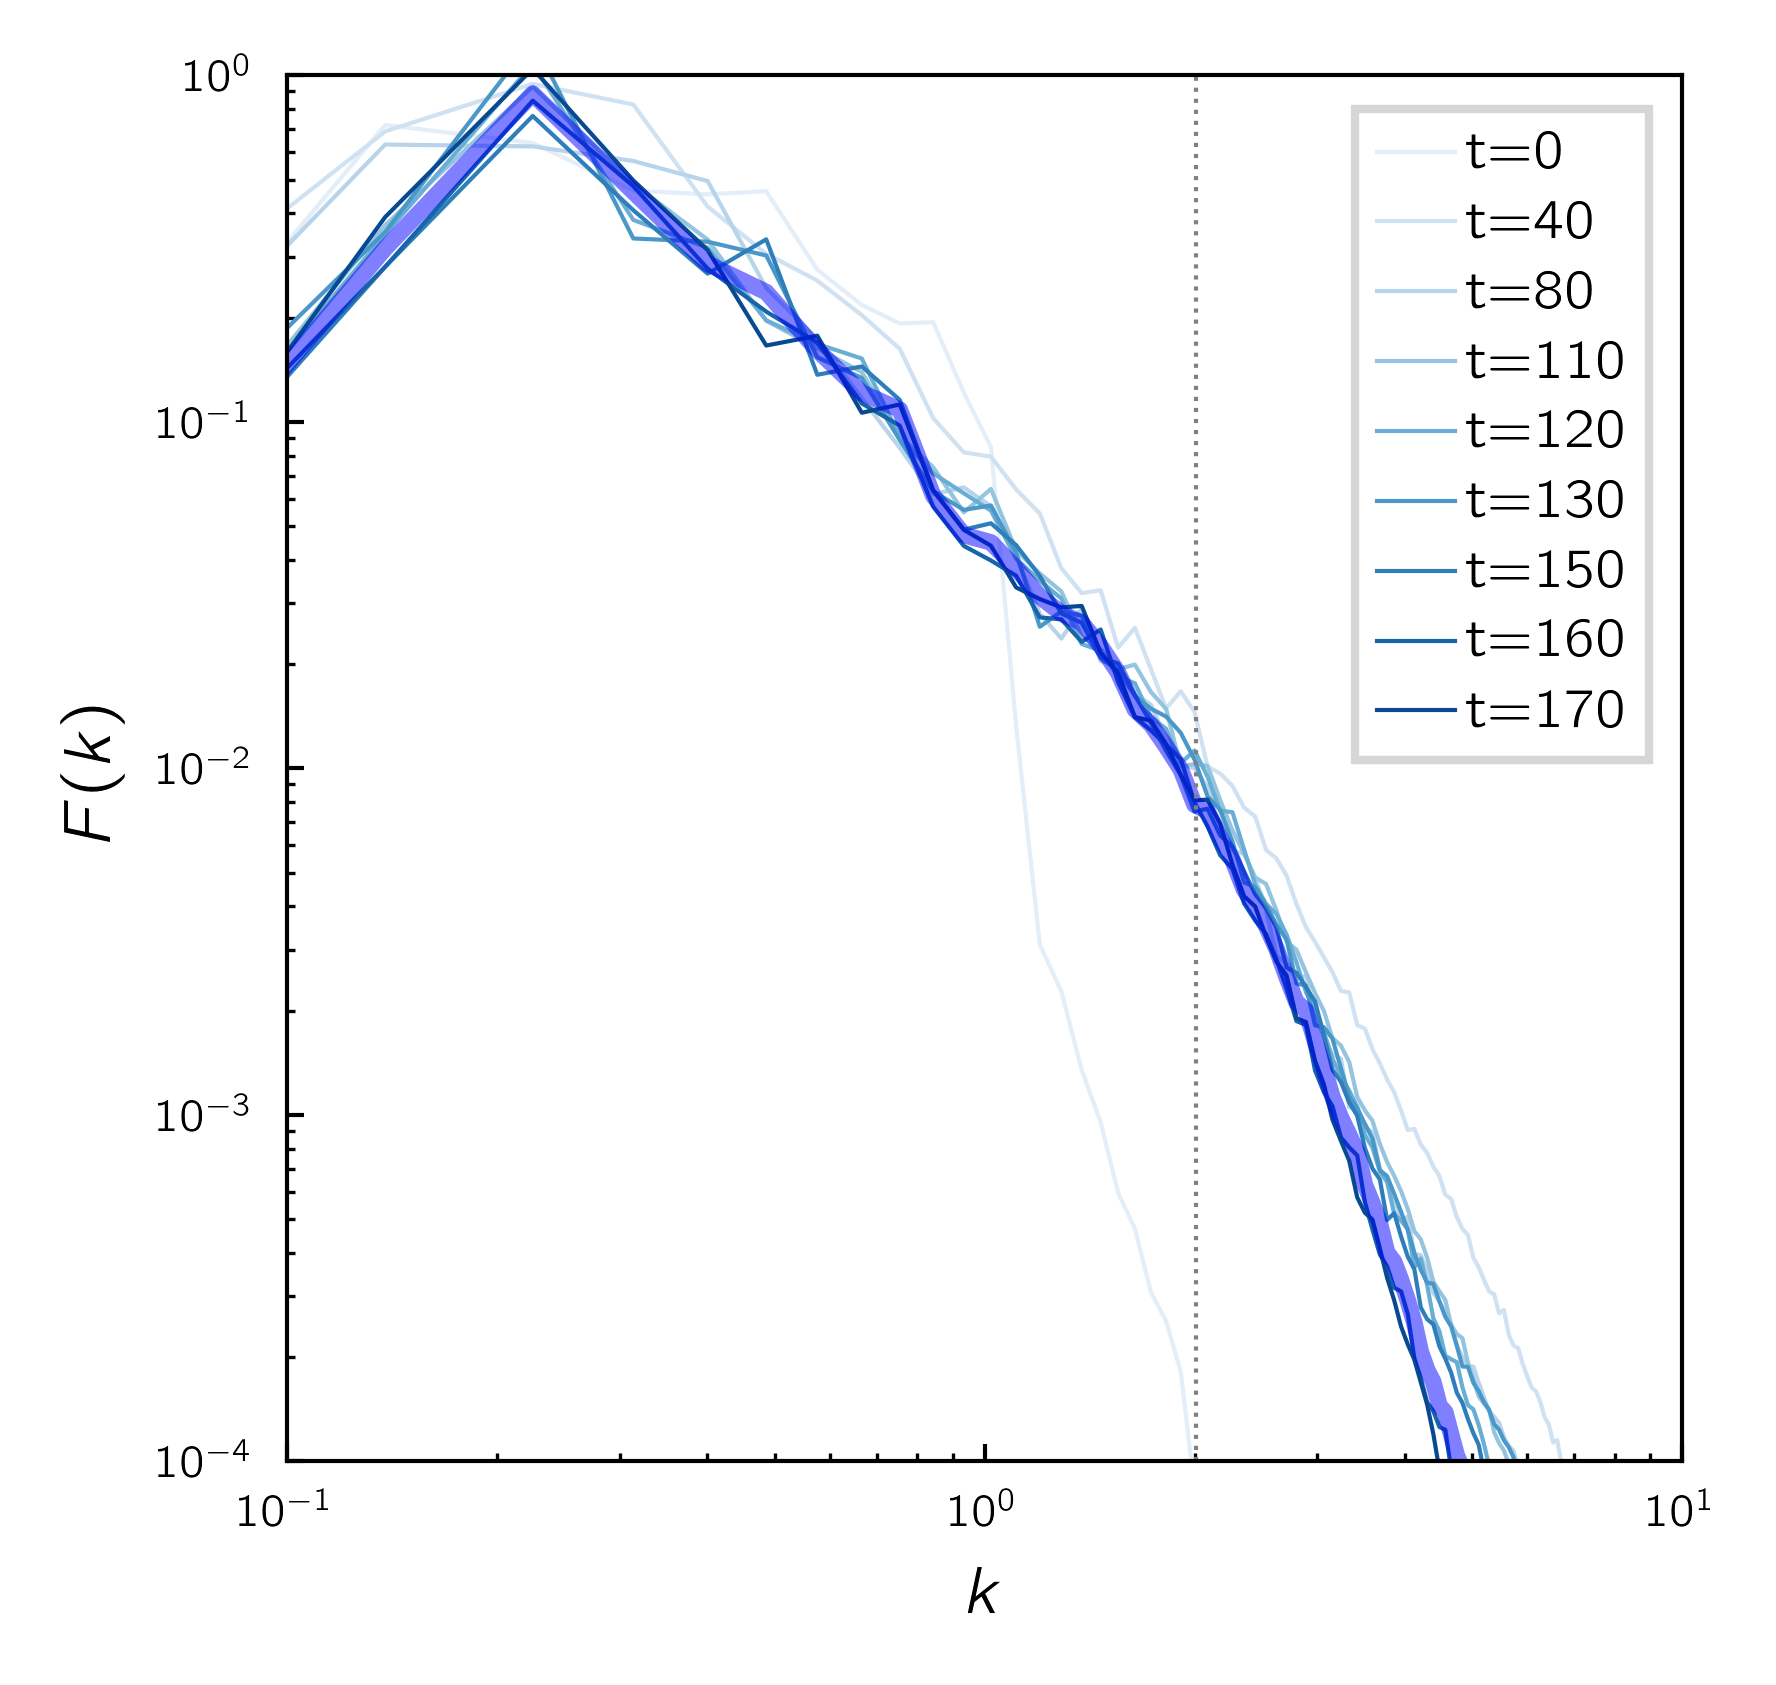

In [70]:
''' Velocity spectrum development over all time samples '''

plt.figure(figsize=[3,3])

linestyles = ['-', ':', '--']
for i in range(9):
    plt.plot(Fux.freq_r*np.pi*2, Fux.isel(t=i), label='t=%g' %Fux.t.isel(t=i),
             c=plt.get_cmap('Blues')((i+1)/10), linestyle=linestyles[0])

plt.plot(Fux.freq_r*np.pi*2, Fux.sel(t=[150,160,170]).mean('t'), lw=2, alpha=0.5)

plt.xlabel('$k$')
plt.ylabel('$F(k)$')
plt.yscale('log'); plt.xscale('log')
plt.ylim([10**(-4),1]); plt.xlim([10**(-1),10])
plt.axvline(x=(1024/16)/200*2*np.pi, linestyle=':', c='gray')
plt.legend()

### Increase vertical resolution (at a particular time)

In [137]:
t = 150
filename = '../../multilayer/JFM2023/compilation/' + 'fieldsample_C4_t%g.nc' %t
ds1 = xr.open_dataset(filename, engine='h5netcdf')
filename = '../../multilayer/JFM2023/compilation/' + 'fieldsample_Cvalid1_t%g.nc' %t
ds2 = xr.open_dataset(filename, engine='h5netcdf')
filename = '../../multilayer/JFM2023/compilation/' + 'fieldsample_Cvalid2_t%g.nc' %t
ds3 = xr.open_dataset(filename, engine='h5netcdf')

window = 'hann'
nfactor = 2
truncate = True
detrend = None
window_correction = True

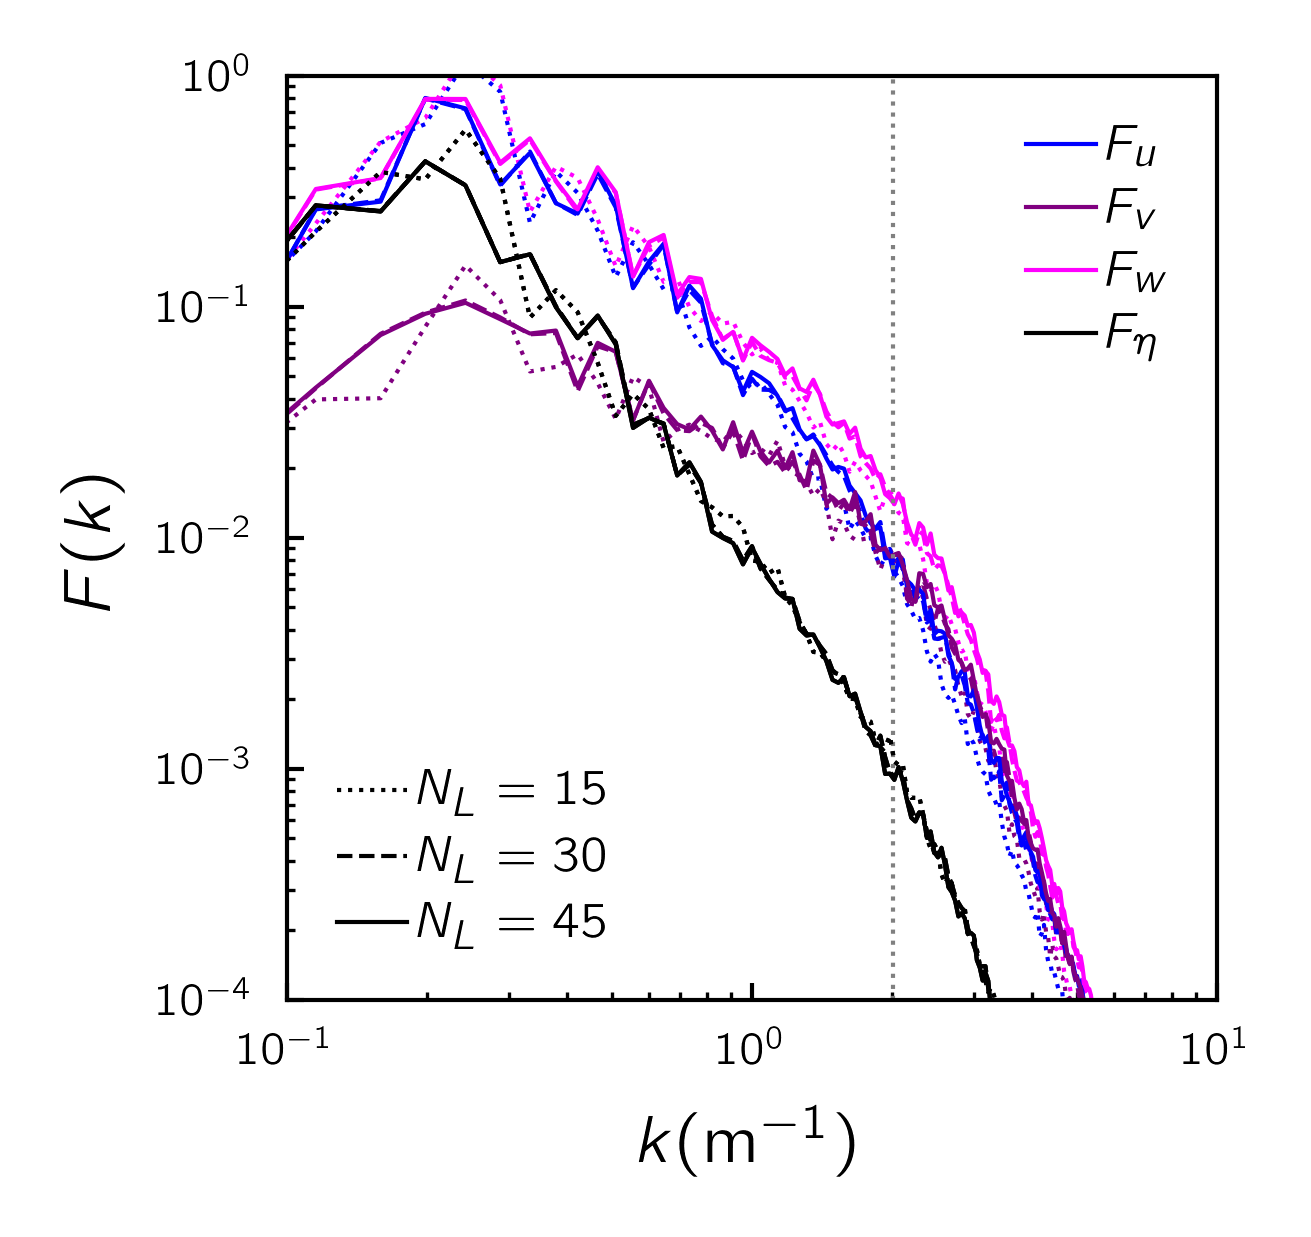

In [161]:
''' Plot all three components at time of choice,
    with three vertical resolutions '''
    
fig = plt.figure(figsize=[2,2]); ax= plt.gca()
linestyles = [':', '--', '-']

# plt.plot()
for i, ds in enumerate([ds1,ds2,ds3]):
    NLAYER = len(ds.z.values)
    Fux = xrft.isotropic_power_spectrum(ds.ux.sel(zl=NLAYER-1).drop(['z']), dim=('x','y'), window=window, nfactor=nfactor, 
                                    truncate=truncate, detrend=detrend, window_correction=window_correction)
    l1, = ax.plot(Fux.freq_r*np.pi*2, Fux, c='blue', linestyle=linestyles[i])
    Fuy = xrft.isotropic_power_spectrum(ds.uy.sel(zl=NLAYER-1).drop(['z']), dim=('x','y'), window=window, nfactor=nfactor, 
                                    truncate=truncate, detrend=detrend, window_correction=window_correction)
    l2, = ax.plot(Fuy.freq_r*np.pi*2, Fuy, c='purple', linestyle=linestyles[i])
    Fuz = xrft.isotropic_power_spectrum(ds.uz.sel(zl=NLAYER-1).drop(['z']), dim=('x','y'), window=window, nfactor=nfactor, 
                                    truncate=truncate, detrend=detrend, window_correction=window_correction)
    l3, = ax.plot(Fuz.freq_r*np.pi*2, Fuz, c='magenta', linestyle=linestyles[i])
    Feta = xrft.isotropic_power_spectrum(ds.z.sel(zl=NLAYER-1).drop(['z']), dim=('x','y'), window=window, nfactor=nfactor, 
                                    truncate=truncate, detrend=detrend, window_correction=window_correction)
    l4, = ax.plot(Feta.freq_r*np.pi*2, Feta, c='black', linestyle=linestyles[i])
    
    
# Optional: add a slope, but it's not isotropic 
# x_vals = np.linspace(1,2)
# y_vals = x_vals**(-5/3)*0.1
# plt.plot(x_vals, y_vals, '--', c='grey')
    
plt.xlabel('$k \mathrm{(m^{-1})}$')
plt.ylabel('$F(k)$')
plt.yscale('log'); plt.xscale('log')
plt.ylim([10**(-4),1]); plt.xlim([10**(-1),10])
plt.axvline(x=(1024/16)/200*2*np.pi, linestyle=':', c='gray')
first_legend = ax.legend([l1,l2,l3,l4], [r'$F_{u}$',r'$F_{v}$',r'$F_{w}$',r'${F_{\eta}}$'], 
                         fontsize=6, frameon=False, loc='upper right')
ax.add_artist(first_legend)

for i, ds in enumerate([ds1,ds2,ds3]):
    NLAYER = len(ds.z.values)
    Feta = xrft.isotropic_power_spectrum(ds.z.sel(zl=NLAYER-1).drop(['z']), dim=('x','y'), window=window, nfactor=nfactor, 
                                    truncate=truncate, detrend=detrend, window_correction=window_correction)
    ax.plot(Feta.freq_r*np.pi*2, Feta, c='black', linestyle=linestyles[i], label='$N_L=%g$' %NLAYER)

# plt.legend(fontsize=6, frameon=False, loc='lower left')
second_legend = ax.legend(fontsize=6, frameon=False, loc='lower left')


### Deeper layer

LAYER 11 out of NLAYER 15 is at depth -1.5.
LAYER 22 out of NLAYER 30 is at depth -1.5.
LAYER 33 out of NLAYER 45 is at depth -1.5.


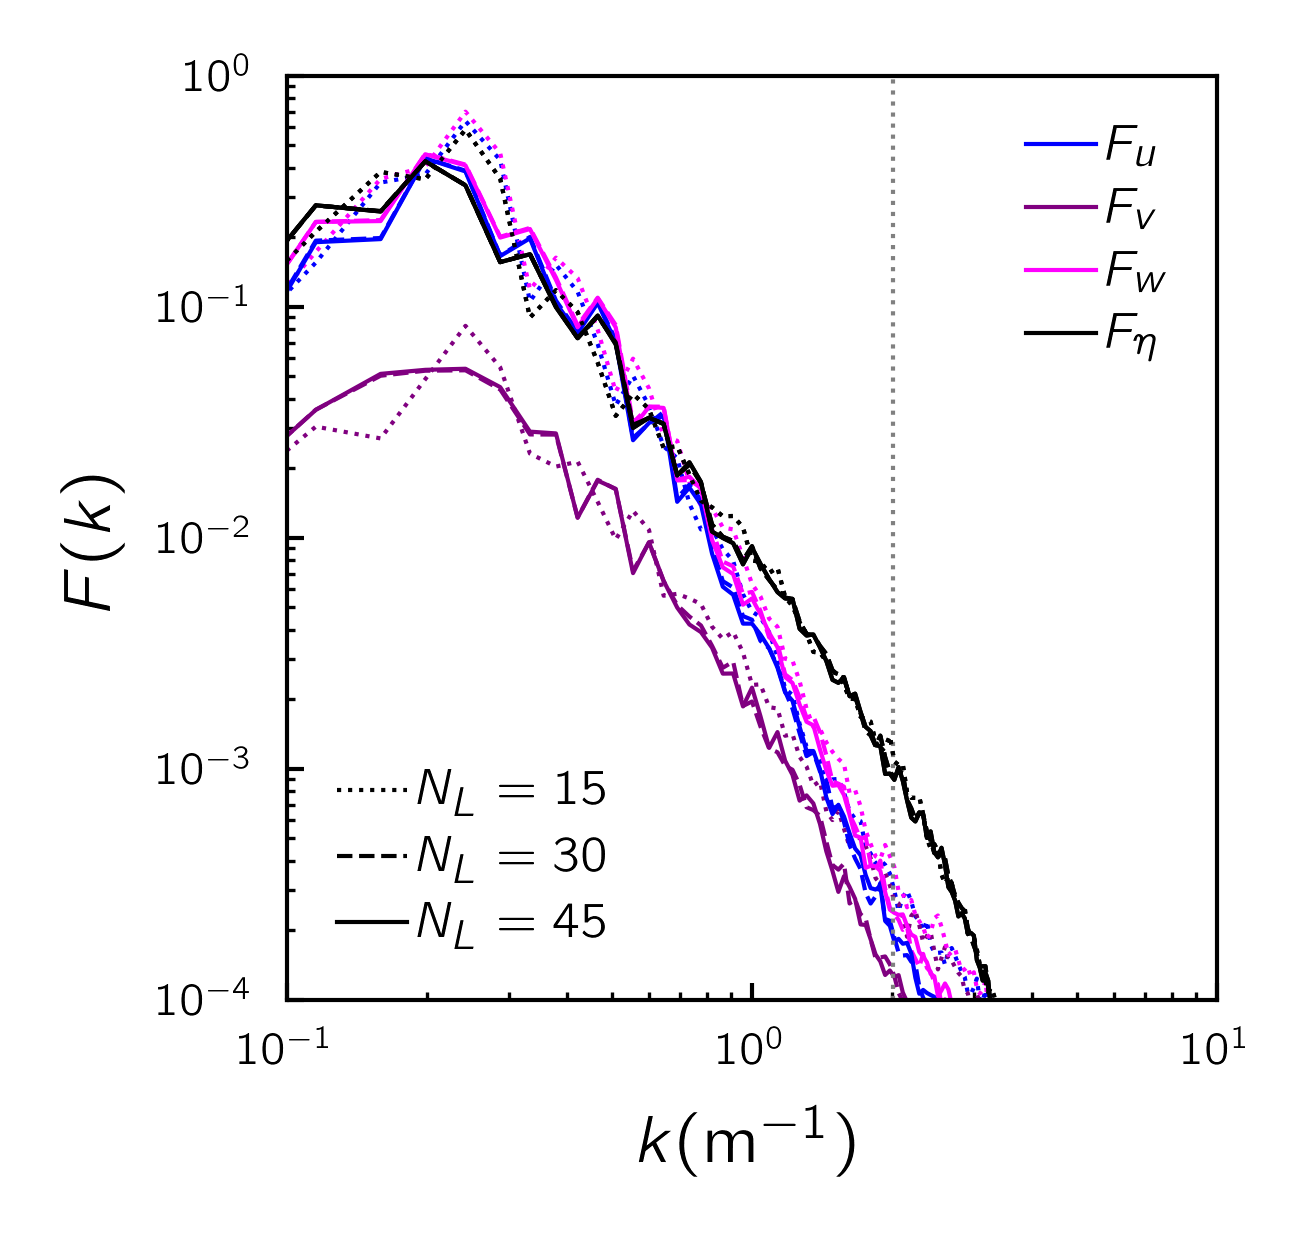

In [166]:
''' Plotting spectrum at a particular depth. '''

depth = -1.5

fig = plt.figure(figsize=[2,2]); ax= plt.gca()
linestyles = [':', '--', '-']

for i, ds in enumerate([ds1,ds2,ds3]):
    NLAYER = len(ds.z.values)
    zmean = ds.z.mean(dim=['x','y'])
    LAYER = np.abs(zmean.values - depth).argmin()
    print('LAYER %g out of NLAYER %g is at depth %g.' %(LAYER,NLAYER,depth))
    
    Fux = xrft.isotropic_power_spectrum(ds.ux.sel(zl=LAYER).drop(['z']), dim=('x','y'), window=window, nfactor=nfactor, 
                                    truncate=truncate, detrend=detrend, window_correction=window_correction)
    l1, = ax.plot(Fux.freq_r*np.pi*2, Fux, c='blue', linestyle=linestyles[i])
    Fuy = xrft.isotropic_power_spectrum(ds.uy.sel(zl=LAYER).drop(['z']), dim=('x','y'), window=window, nfactor=nfactor, 
                                    truncate=truncate, detrend=detrend, window_correction=window_correction)
    l2, = ax.plot(Fuy.freq_r*np.pi*2, Fuy, c='purple', linestyle=linestyles[i])
    Fuz = xrft.isotropic_power_spectrum(ds.uz.sel(zl=LAYER).drop(['z']), dim=('x','y'), window=window, nfactor=nfactor, 
                                    truncate=truncate, detrend=detrend, window_correction=window_correction)
    l3, = ax.plot(Fuz.freq_r*np.pi*2, Fuz, c='magenta', linestyle=linestyles[i])
    Feta = xrft.isotropic_power_spectrum(ds.z.sel(zl=NLAYER-1).drop(['z']), dim=('x','y'), window=window, nfactor=nfactor, 
                                    truncate=truncate, detrend=detrend, window_correction=window_correction)
    l4, = ax.plot(Feta.freq_r*np.pi*2, Feta, c='black', linestyle=linestyles[i])
    
plt.xlabel('$k \mathrm{(m^{-1})}$')
plt.ylabel('$F(k)$')
plt.yscale('log'); plt.xscale('log')
plt.ylim([10**(-4),1]); plt.xlim([10**(-1),10])
plt.axvline(x=(1024/16)/200*2*np.pi, linestyle=':', c='gray')
first_legend = ax.legend([l1,l2,l3,l4], [r'$F_{u}$',r'$F_{v}$',r'$F_{w}$',r'${F_{\eta}}$'], 
                         fontsize=6, frameon=False, loc='upper right')
ax.add_artist(first_legend)

for i, ds in enumerate([ds1,ds2,ds3]):
    NLAYER = len(ds.z.values)
    Feta = xrft.isotropic_power_spectrum(ds.z.sel(zl=NLAYER-1).drop(['z']), dim=('x','y'), window=window, nfactor=nfactor, 
                                    truncate=truncate, detrend=detrend, window_correction=window_correction)
    ax.plot(Feta.freq_r*np.pi*2, Feta, c='black', linestyle=linestyles[i], label='$N_L=%g$' %NLAYER)

# plt.legend(fontsize=6, frameon=False, loc='lower left')
second_legend = ax.legend(fontsize=6, frameon=False, loc='lower left')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


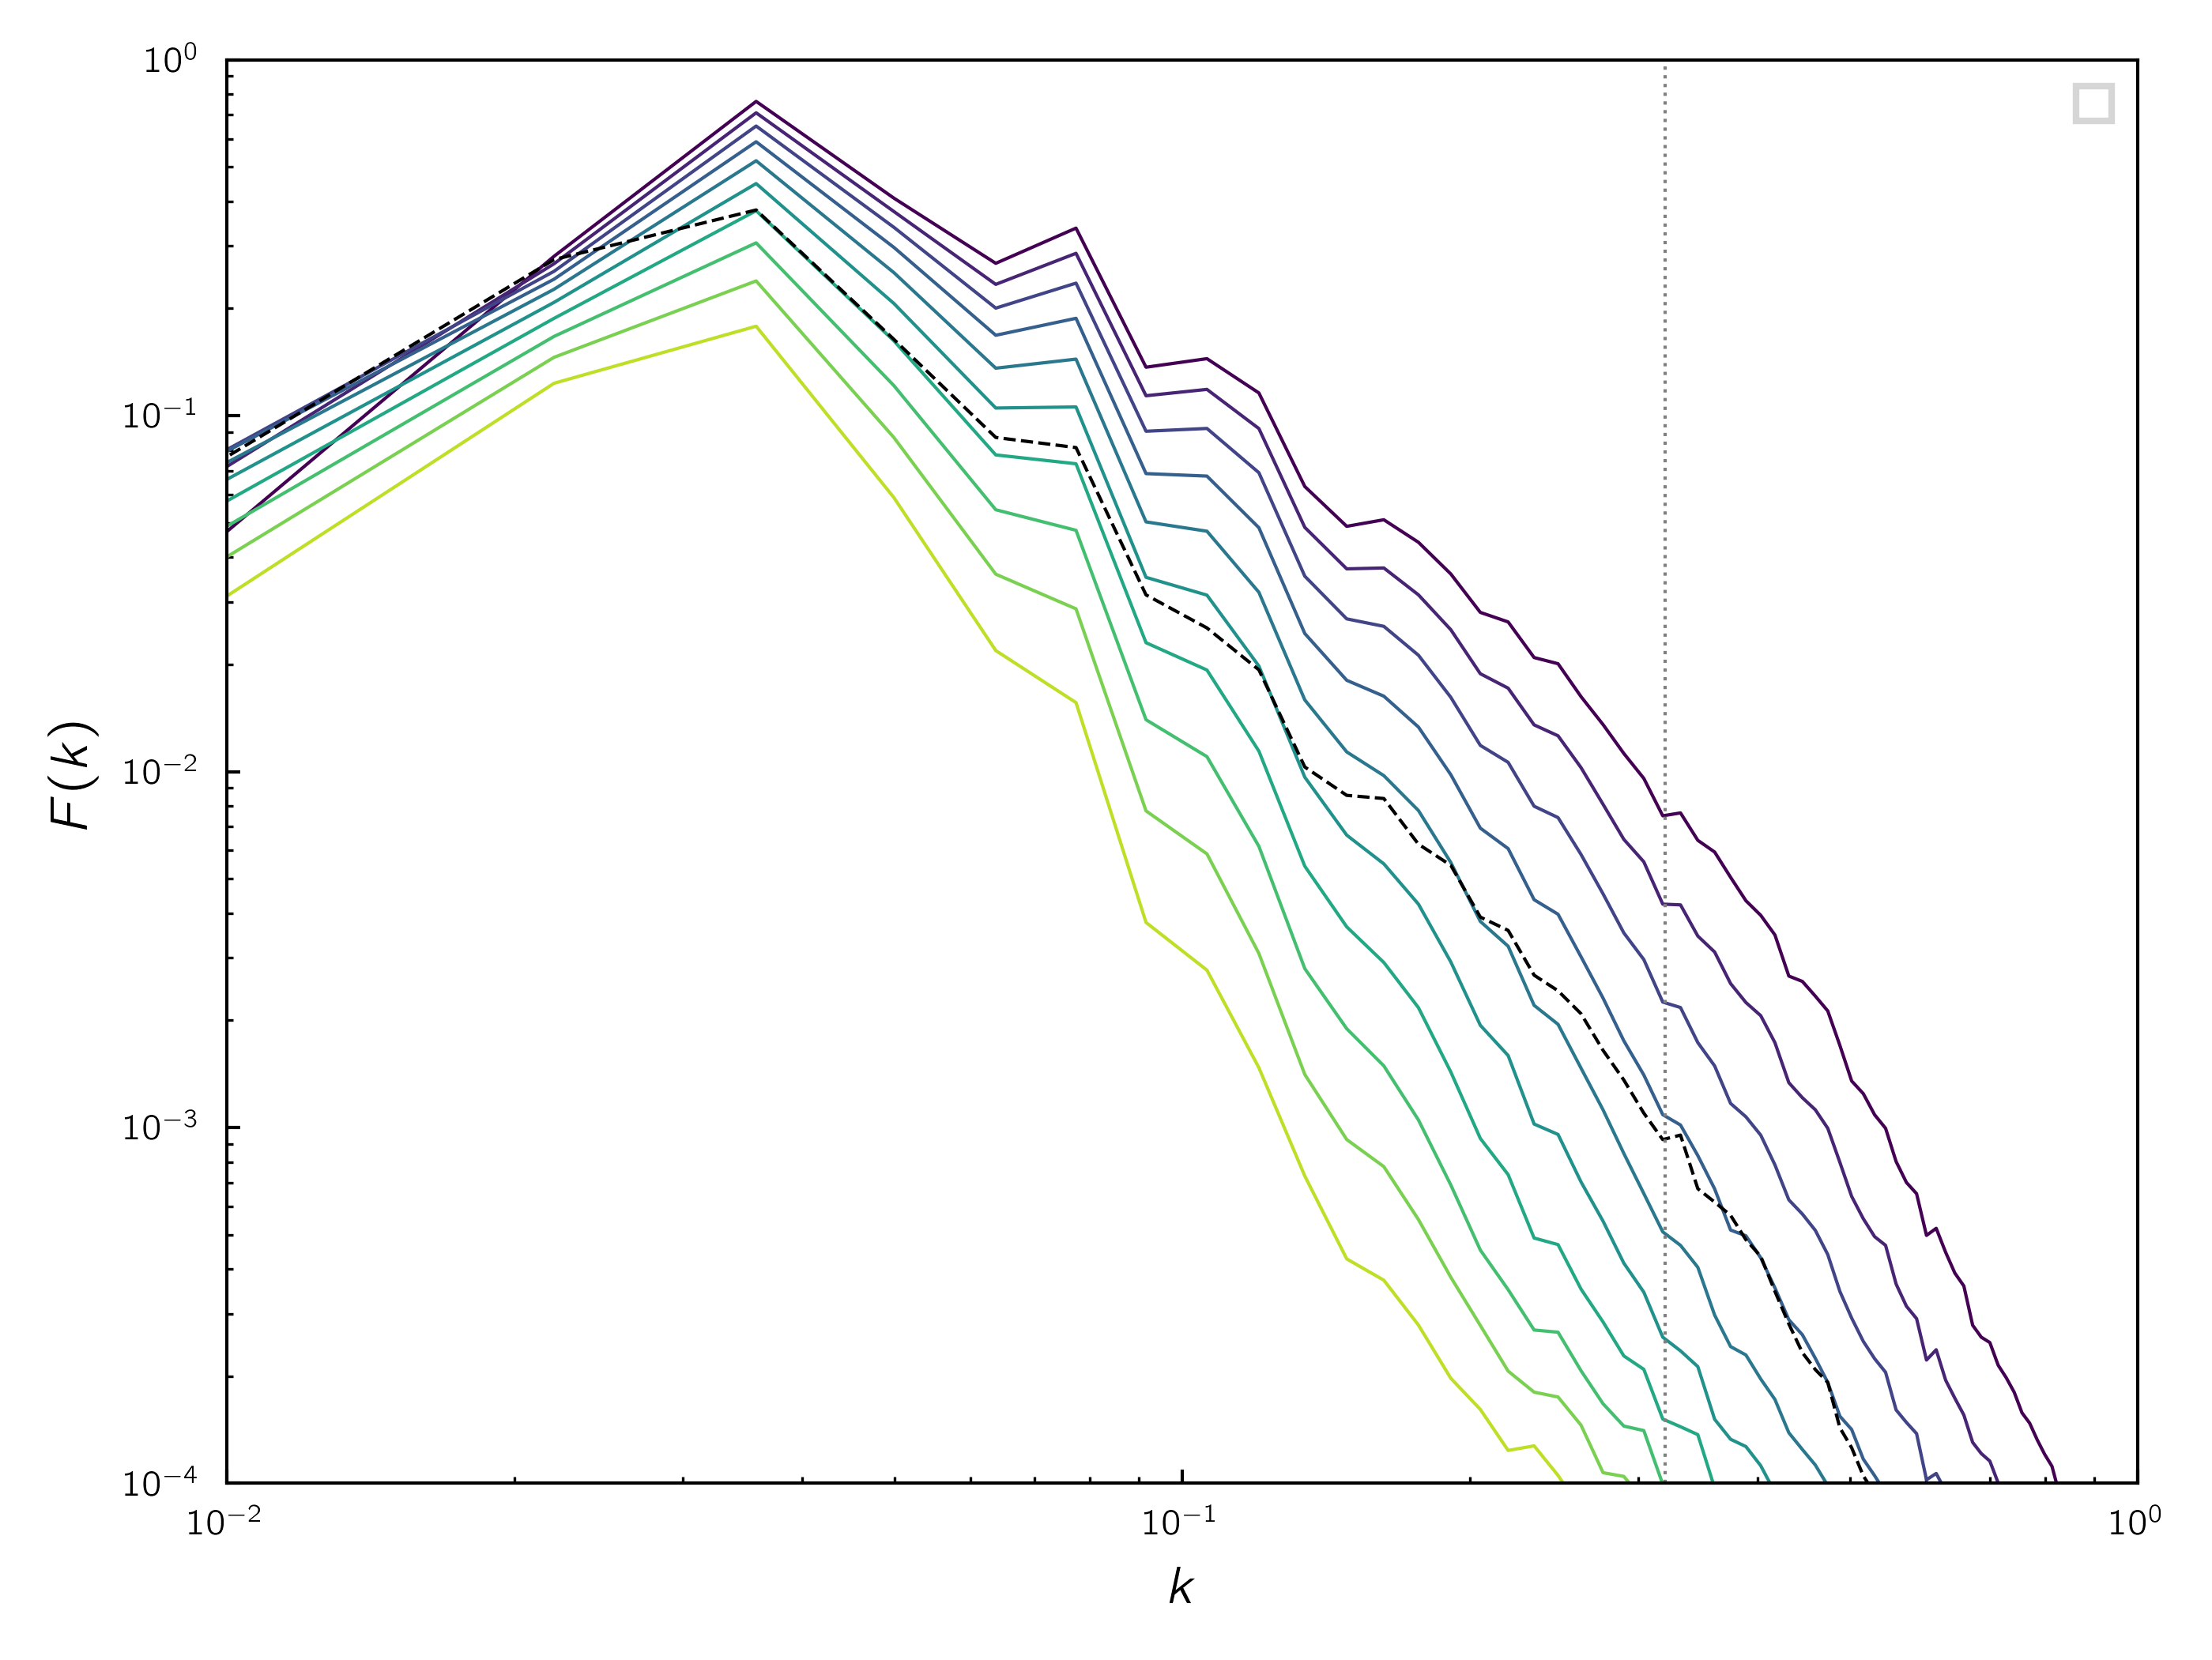

In [12]:
ds = ds3

NLAYER = len(ds.z.values)
for i in range(0,20,2):
    Fux = xrft.isotropic_power_spectrum(ds.ux.sel(zl=NLAYER-i-1).drop(['z']), dim=('x','y'), window=window, nfactor=nfactor, 
                                    truncate=truncate, detrend=detrend, window_correction=window_correction)
    Fux.plot(c=plt.get_cmap('viridis')(i/20))
    
Feta = xrft.isotropic_power_spectrum(ds.z.sel(zl=NLAYER-1).drop(['z']), dim=('x','y'), window=window, nfactor=nfactor, 
                                truncate=truncate, detrend=detrend, window_correction=window_correction)
Feta.plot(linestyle='--', c='k')
    
plt.xlabel('$k$')
plt.ylabel('$F(k)$')
plt.yscale('log'); plt.xscale('log')
plt.ylim([10**(-4),1]); plt.xlim([10**(-2),1])
plt.axvline(x=(1024/16)/200, linestyle=':', c='gray')
plt.legend()


### Check spectrum computation and total energy

In [47]:
nfactor = 1
truncate = False
detrend = None
window_correction = False

eta = ds.z.sel(zl=NLAYER-1) - ds.z.sel(zl=NLAYER-1).mean(dim=['x','y'])
Feta = xrft.isotropic_power_spectrum(eta.drop(['z']), dim=('x','y'), nfactor=nfactor, 
                                truncate=truncate, detrend=detrend, window_correction=window_correction)
# plt.plot(Feta.freq_r*np.pi*2, Feta, linestyle='--', c='k')
print((eta**2).mean(dim=['x','y']))
print(Feta.integrate('freq_r')*2*np.pi)
print(Feta.sum('freq_r')*np.diff(Feta.freq_r).mean()*2*np.pi)

<xarray.DataArray 'z' ()>
array(0.13395678)
<xarray.DataArray ()>
array(0.13273403)
<xarray.DataArray ()>
array(0.13273882)


/Users/jiarongw/miniconda3/envs/gp-tigressdata/lib/python3.10/site-packages/xrft/xrft.py:1054: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)


### Check energy convergence (need to update with the latest rand=4)

In [ ]:
import pandas as pd
fig = plt.figure(figsize=[3,3])
for nlayer in (15,30,45):
    energy = pd.read_table('../../multilayer/JFM2023/temp/' + 'energy_before_remap_%g.dat' %nlayer, delimiter=' ', names=['t','ke','gpe'])
    energy = energy.drop_duplicates(subset=['t'])
    norm = energy['ke'][0] + energy['gpe'][0]
    plt.plot(np.array(energy.t), np.array(energy['ke']+energy['gpe'])/norm, 
             label='$N_l=%g$' %nlayer)
    plt.xlabel('$t$'); plt.ylabel('$E/E_0$'); plt.legend()